In [2]:
import os
import numpy as np
import glob
import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import cv2
import torch.functional as F
from io import open
from PIL import Image
from numpy import sqrt
import matplotlib.pyplot as plt

In [3]:
# Import helper functions
def split_dir_to_train_test_val(directory = "images/",
                            train_size = 0.7,
                            test_size = 0.2,
                            val_size = 0.1):
      """
      Creates 3 folders for Train, Test and Validation data
      """
      import os
      import random
      import shutil
    
      # Set random seed
      rng = random.Random(42)
    
      for root, folders, files in os.walk(directory):
        for folder in folders:
          # Create list of the files
          list_of_files = []
          for file_name in os.listdir(root+folder+"/"):
            list_of_files.append(file_name)
          
          #  Shuffle the list
          rng.shuffle(list_of_files)
    
          # Create lists of files
          train_files = list_of_files[:int(len(list_of_files)*train_size)]
          test_files = list_of_files[int(len(list_of_files)*train_size) : int(len(list_of_files)*(train_size+test_size))]
          val_files = list_of_files[int(len(list_of_files)*(train_size+test_size)):]
    
          # Create folders and files for train data
          for one_file in train_files:
          
            # Copy  files
            dest_dir = "files/train/"+folder+"/"
            os.makedirs(dest_dir, exist_ok=True)
    
            shutil.copy2(src=(root+folder+"/"+one_file),
                        dst=(dest_dir+one_file))
          print(f"Folder {folder}. Train data copied. {len(train_files)} files")
    
          # Create folders and files for test data
          for one_file in test_files:      
            # Copy  files
            dest_dir = "files/test/"+folder+"/"
            os.makedirs(dest_dir, exist_ok=True)
    
            shutil.copy2(src=(root+folder+"/"+one_file),
                        dst=(dest_dir+one_file))
          print(f"Folder {folder}. Test data copied. {len(test_files)} files")
    
          # Create folders and files for validation data
          for one_file in val_files:
          
            # Copy  files
            dest_dir = "files/validation/"+folder+"/"
            os.makedirs(dest_dir, exist_ok=True)
    
            shutil.copy2(src=(root+folder+"/"+one_file),
                        dst=(dest_dir+one_file))
          print(f"Folder {folder}. Validation data copied. {len(val_files)} files")
      
     


def get_class_names(directory):
      """
      Get the classnames from train folder for example
      """
      import pathlib
      import numpy as np
      data_dir = pathlib.Path(directory)
      class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class names 
      return class_names
      print(class_names)

In [ ]:
split_dir_to_train_test_val(directory = "/kaggle/input/oct-classification-data/classification data/",
                            train_size = 0.7,
                            test_size = 0.2,
                            val_size = 0.1)

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(300,300)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    v2.Grayscale(1)
])

In [29]:
train_path = '/kaggle/working/files/train'
test_path = '/kaggle/working/files/test'
val_path = '/kaggle/working/files/validation'

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform = transform),
    batch_size = 32,
    shuffle = True
)
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform = transform),
    batch_size = 32,
    shuffle = True
)
validation_loader = DataLoader(
    torchvision.datasets.ImageFolder(val_path, transform = transform),
    batch_size = 32,
    shuffle = True
)

In [6]:
#class_names
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['0', '1', '2']


In [7]:
#CNN network
class ConvNet(nn.Module):
    def __init__(self,num_classes=3):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (32,1,300,300)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (32,12,300,300)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (32,12,300,300)
        self.relu1=nn.ReLU()
      #Shape= (32,12,300,300)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
       #Shape= (32,12,150,150)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
       #Shape= (32,20,150,150)
        self.relu2=nn.ReLU()
        #Shape= (32,20,150,150)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (32,32,150,150)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (32,32,150,150)
        self.relu3=nn.ReLU()
        #Shape= (32,32,150,150)
        
        
        self.fc=nn.Linear(in_features=32*150*150,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with #Shape= (32,32,150,150)
            
        output=output.view(-1, 32*150*150)
            
            
        output=self.fc(output)
            
        return output

In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=ConvNet(num_classes=3).to(device)

In [9]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [10]:
train_count=len(glob.glob(train_path+'/**/*.tiff'))
test_count=len(glob.glob(test_path+'/**/*.tiff'))
print(train_count,test_count)

12624 3608


In [11]:
best_accuracy=0.0
num_epochs = 25
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    val_loss = 0.0
    
    for i, (images,labels) in enumerate(train_loader):
        
        images=Variable(images.to(device))
        labels=Variable(labels.to(device))
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.to(device))
            labels=Variable(labels.to(device))
        
        outputs = model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    train_losses.append(train_loss)
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 Train Loss: tensor(12.0975) Train Accuracy: 0.7124524714828897 Test Accuracy: 0.8001662971175166
Epoch: 1 Train Loss: tensor(1.9181) Train Accuracy: 0.8686628643852978 Test Accuracy: 0.7960088691796009
Epoch: 2 Train Loss: tensor(0.5589) Train Accuracy: 0.9226077313054499 Test Accuracy: 0.916019955654102
Epoch: 3 Train Loss: tensor(0.2608) Train Accuracy: 0.9496197718631179 Test Accuracy: 0.9204545454545454
Epoch: 4 Train Loss: tensor(0.1114) Train Accuracy: 0.9714036755386565 Test Accuracy: 0.9107538802660754
Epoch: 5 Train Loss: tensor(0.0802) Train Accuracy: 0.9778992395437263 Test Accuracy: 0.9149113082039911
Epoch: 6 Train Loss: tensor(0.0420) Train Accuracy: 0.9871673003802282 Test Accuracy: 0.8971729490022173
Epoch: 7 Train Loss: tensor(0.0319) Train Accuracy: 0.9898605830164765 Test Accuracy: 0.9273835920177383
Epoch: 8 Train Loss: tensor(0.0517) Train Accuracy: 0.9823352344740177 Test Accuracy: 0.9334811529933481
Epoch: 9 Train Loss: tensor(0.0322) Train Accuracy: 0.9

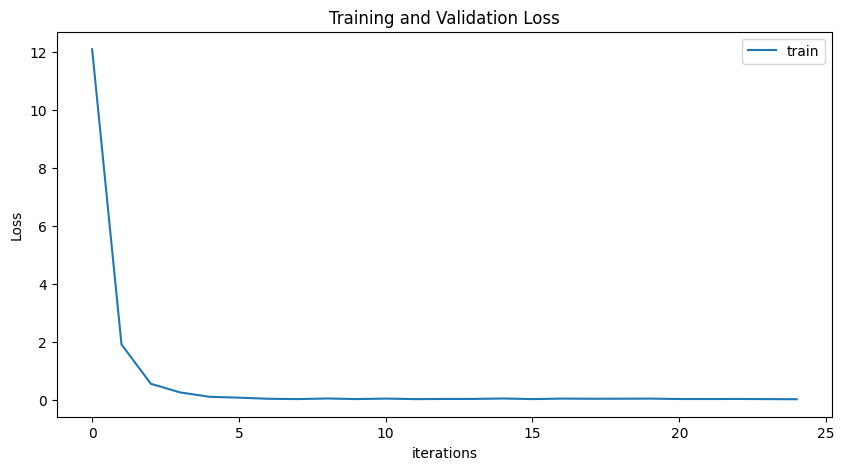

In [12]:
#print(train_losses)
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **testing the model**

In [13]:
print(classes)

['0', '1', '2']


In [14]:
val_path = '/kaggle/working/files/validation'


In [15]:
checkpoint  = torch.load('/kaggle/working/best_checkpoint.model')

In [16]:
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=720000, out_features=3, bias=True)
)

In [17]:
transformer = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(300,300)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    v2.Grayscale(1)
])

**prediction function**

In [18]:
def predict(img_path, transformer):
    image = Image.open(img_path)
    img_tens = transformer(image).float()
    img_tens = img_tens.unsqueeze_(0)
    input = Variable(img_tens.to(device))
    
    output = model(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    pred = classes[index]
    predictions = ['normal', 'diabetic macular degeneration', 'non-diabetic macular disease']
    prediction = None
    if pred == '0':
        prediction = predictions[0]
    elif pred == '1':
        prediction = predictions[1]
    elif pred == '2':
        prediction = predictions[2]
        
    return prediction


In [53]:
state = predict('/kaggle/working/classified/2/RawDataQA (9)/(16).tif', transformer)
print(state)

non-diabetic macular disease


In [26]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()


In [30]:
check_accuracy(validation_loader, model)

Got 1691 / 1806 with accuracy 93.63


# put the test folders into their classes

In [51]:
import shutil

def classify_subfolders(root_folder, model, transform, output_folder):

    # Set the model to evaluation mode
    model.eval()

    # Initialize dictionaries to store the class counts for each subfolder
    class_counts = {}

    # Iterate through the root folder and its subfolders
    for subdir, dirs, files in os.walk(root_folder):
        # Initialize counts for each class
        class_counts[subdir] = {0: 0, 1: 0, 2: 0}

        # Iterate through the files in the subfolder
        for file in files:
            # Load and transform the image
            image_path = os.path.join(subdir, file)
            image = Image.open(image_path)
            image = transform(image).float()
            image = image.unsqueeze(0)
            input = Variable(image.to(device))

            # Pass the image through the model
            with torch.no_grad():
                output = model(input)

            # Get the predicted class
            _, predicted_class = torch.max(output, 1)

            # Update the class counts for the subfolder
            class_counts[subdir][predicted_class.item()] += 1

    # Determine the mode class for each subfolder
    mode_classes = {}
    for subdir, counts in class_counts.items():
        mode_class = max(counts, key=counts.get)
        mode_classes[subdir] = mode_class

    # Create output folders for each mode class
    # Create output folders for each mode class
    for i in range(3):
        os.makedirs(os.path.join(output_folder, str(i)), exist_ok=True)

    # Move subfolders to their respective mode class folders
    for subdir, mode_class in mode_classes.items():
        source_path = subdir
        dest_path = os.path.join(output_folder, str(mode_class), os.path.basename(subdir))
        shutil.copytree(source_path, dest_path)
root_folder = '/kaggle/input/test-data-2/ICIP_test_data_final'
output = 'classified/'
# Call the function to classify subfolders
classify_subfolders(root_folder, model, transformer, output)


In [57]:
def classify_images(root_folder, model, class_labels, transform):
    model.eval()

    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                # Load and transform the image
                image = Image.open(file_path)
                image = transform(image).float()
                image = image.unsqueeze(0)
                input = Variable(image.to(device))

                with torch.no_grad():
                    output = model(input)
                _, predicted = torch.max(output, 1)
                predicted_class = class_labels[predicted.item()]
                destination_folder = os.path.join(subdir, predicted_class)
                if not os.path.exists(destination_folder):
                    os.makedirs(destination_folder)
                os.rename(file_path, os.path.join(destination_folder, file))
            except Exception as e:
                print(f"Error processing {file_path}: {e}")


In [58]:
class_labels = ['0', '1', '2']
root_folder = '/kaggle/working/classified'
classify_images(root_folder, model, class_labels, transformer)